In [1]:
#import librairies
from skimage import io
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from google.colab.patches import cv2_imshow
from google.colab import drive
import copy
%matplotlib inline
import skimage.filters
import skimage.exposure
import skimage.filters.rank
import skimage.morphology
import scipy.ndimage
import matplotlib.image as img
from skimage.feature import hessian_matrix, hessian_matrix_eigvals
from skimage.filters import hessian
from skimage import morphology

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


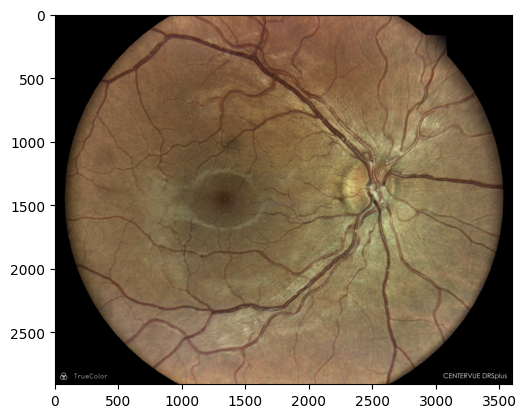

In [30]:
image = io.imread('/content/drive/MyDrive/App/DATA_PREPROCESSING/0/a105-CHU-l.jpg')
plt.imshow(image)

In [31]:
#using channel
#channel splitting
imgR = image[:,:,0]
imgG = image[:,:,1]
imgB = image[:,:,2]

In [32]:
median=cv2.addWeighted ( imgG,4, cv2.medianBlur(imgG, ksize=99),-4 ,128)

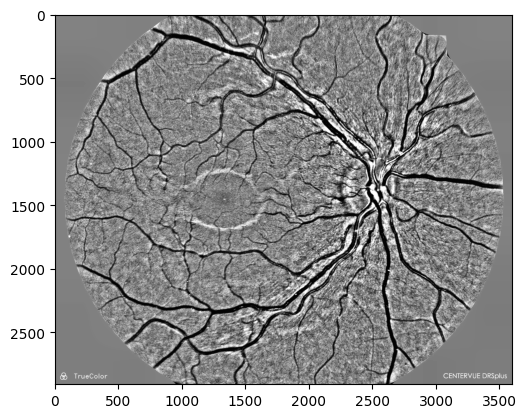

In [33]:
clahe = cv2.createCLAHE(clipLimit=3.0)
clahe_imgG_median = clahe.apply(median)
plt.imshow(clahe_imgG_median,cmap='gray')

In [34]:
#blue,green,red = cv2.split(final) #séparation des canaux BGR
# une opération de morphologie d'ouverture sur le canal vert (érosion suivie de dilatation)
r1 = cv2.morphologyEx(clahe_imgG_median, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)), iterations= 1)
# une opération de morphologie d'ouverture sur le canal vert (dilatation suivie de l'érosion )
R1 = cv2.morphologyEx(r1, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9)), iterations = 1)
r2 = cv2.morphologyEx(R1, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18,18)), iterations = 1)
R2 = cv2.morphologyEx(r2, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (18,18)), iterations = 1)
r3 = cv2.morphologyEx(R2, cv2.MORPH_OPEN, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (40,40)), iterations = 1)
R3 = cv2.morphologyEx(r3, cv2.MORPH_CLOSE, cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (50,50)), iterations = 1)
f4 = cv2.subtract(R3, clahe_imgG_median)
f5 = clahe.apply(f4)

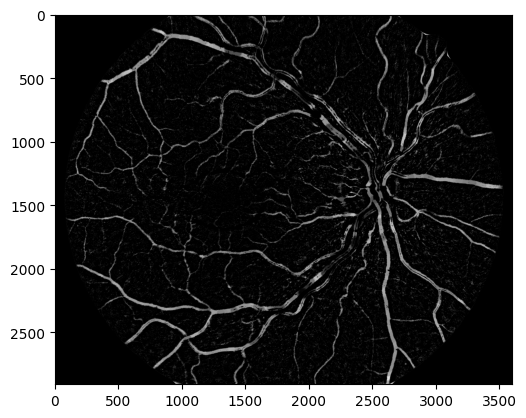

In [35]:
plt.imshow(f4, cmap='gray')
plt.show()

In [36]:
#thresholding function
def threshold(img,k):
    ret = copy.deepcopy(img)
    ret[ret<k] = 0
    ret[ret>=k] = 255
    return ret

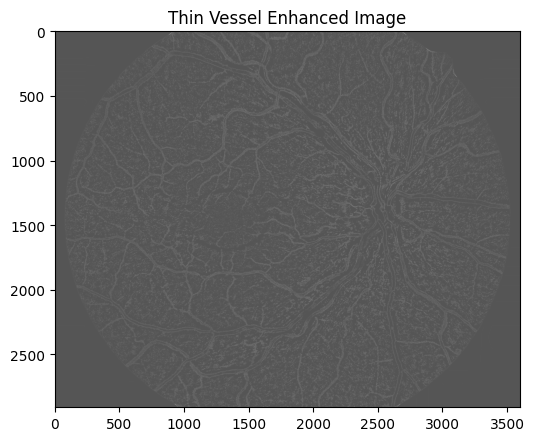

In [37]:
#hessian matrix and eigenvalues approach to get thin vessel enhanced image
HessThin = hessian_matrix(f5, sigma=0.5, order='rc')
EignThin = hessian_matrix_eigvals(HessThin) [1]
fig = plt.figure(figsize=(6, 6))
plt.title("Thin Vessel Enhanced Image")
plt.imshow(1-EignThin, cmap=plt.cm.gray)

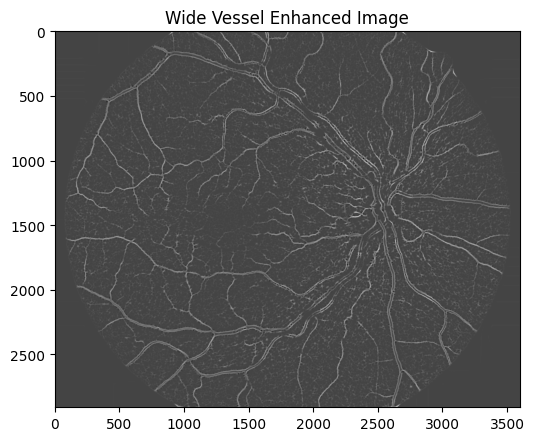

In [38]:
#hessian matrix and eigenvalues approach to get wide vessel enhanced image
HessWide = hessian_matrix(f5, sigma=4, order='rc')
EignWide = hessian_matrix_eigvals(HessWide) [1]
fig = plt.figure(figsize=(6, 6))
plt.title("Wide Vessel Enhanced Image")
plt.imshow(1-EignWide, cmap='gray')

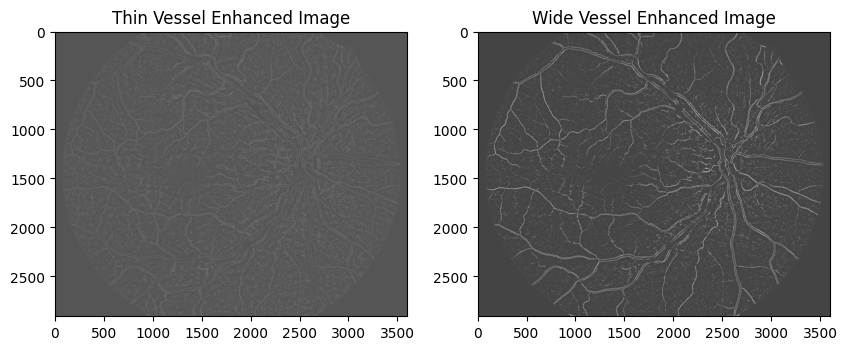

In [39]:
fig = plt.figure(figsize=(10,10))
fig.add_subplot(1, 2, 1)
plt.title("Thin Vessel Enhanced Image")
plt.imshow(1-EignThin, cmap=plt.cm.gray)
fig.add_subplot(1, 2, 2)
plt.title("Wide Vessel Enhanced Image")
plt.imshow(1-EignWide, cmap='gray')

In [40]:
#global otsu thresholding function
def GlobalOtsu(img):
    foreground = img[img>=0]
    background = img[img<0]

    final_var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))
    if(np.isnan(final_var)):
        final_var = -1

    final_thresh = 0
    for i in np.linspace(np.min(img), np.max(img), num=255):
        foreground = img[img>=i]
        background = img[img<i]
        var = (np.var(foreground) * len(foreground) + np.var(background) * len(background))/(len(foreground) + len(background))

        if(np.isnan(var)):
            var = -1

        if(var!=-1 and (var<final_var or final_var ==-1)):
            final_var = var
            final_thresh = i
    return threshold(img,final_thresh)

In [41]:
#Area based thresholding/cleaning. Done as postprocessing step
def AreaThreshold(img, area = 5):
    nlabels,labels,stats,centroid = cv2.connectedComponentsWithStats(np.uint8(img), 4, cv2.CV_32S)

    output = np.copy(img)

    for i in range(output.shape[0]):
        for j in range(output.shape[1]):
            if stats[labels[i][j], cv2.CC_STAT_AREA] < area:
                output[i][j] = 0

    return output

In [42]:
#Local otsu thresholding
from skimage.filters import threshold_otsu, rank
from skimage.morphology import disk

def LocalOtsu1(img,radius = 5):
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)

    output[output < local_otsu] = 0
    output[output >= local_otsu] = 255

    return output

In [43]:
#local Otsu thresholding function as per paper with offset included
def LocalOtsu2(img,radius = 15):
    selem = disk(radius)

    local_otsu = rank.otsu(img, selem)
    output = np.copy(img)
    rng = local_otsu.max() - local_otsu.min()
    mid = rng/2 + local_otsu.min()

    local_otsu[local_otsu<mid] = mid

    output[output < local_otsu] = 0


    return output

In [44]:
import pywt

#using wavelet method for image fusion
def image_fusion(img1,img2):
    w1 = pywt.wavedec2(img1, 'db1')
    w2 = pywt.wavedec2(img2, 'db1')
    elem = (w1[0]+w2[0])/2
    fw = [elem]

    for i in range(len(w1)-1):
        x,y,z = (w1[i+1][0] + w2[i+1][0])/2, (w1[i+1][1] + w2[i+1][1])/2, (w1[i+1][2] + w2[i+1][2])/2
        fw.append((x,y,z))

    output = pywt.waverec2(fw, 'db1')

#     Normalisation, May or May not be required
    amin = np.min(output)
    amax = np.max(output)
    output = 255* ((output - amin)/(amax-amin))

    output = cv2.resize(output,img1.T.shape)
    return output

In [45]:
#Global otsu thresholding
val1 = GlobalOtsu(1-EignWide)

Text(0.5, 1.0, 'GlobalThresholdedThickVessel')

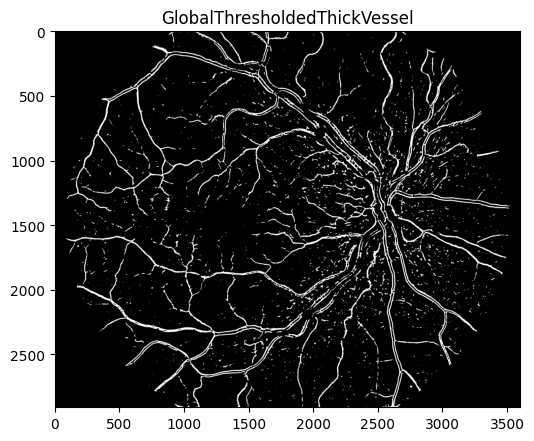

In [46]:
#Global otsu thresholded image
fig = plt.figure(figsize=(6, 6))
plt.imshow(val1,cmap='gray')
plt.title("GlobalThresholdedThickVessel")

In [47]:
#normalising the images for further processing
thinN = cv2.normalize(1-EignThin,  None, 0, 255, cv2.NORM_MINMAX)
val1 = cv2.normalize(val1,  None, 0, 70, cv2.NORM_MINMAX)

Text(0.5, 1.0, 'Thin vessels enhanced')

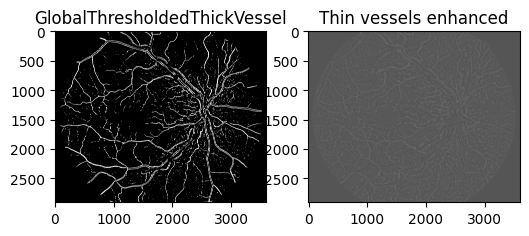

In [48]:
#Two images that have to be fused
fig = plt.figure(figsize=(6, 6))
fig.add_subplot(1, 2, 1)
plt.imshow(val1,cmap='gray')
plt.title('GlobalThresholdedThickVessel')
fig.add_subplot(1, 2, 2)
plt.imshow(thinN,cmap='gray')
plt.title('Thin vessels enhanced')

In [49]:
#fusing the images
test1 = image_fusion(val1,thinN)

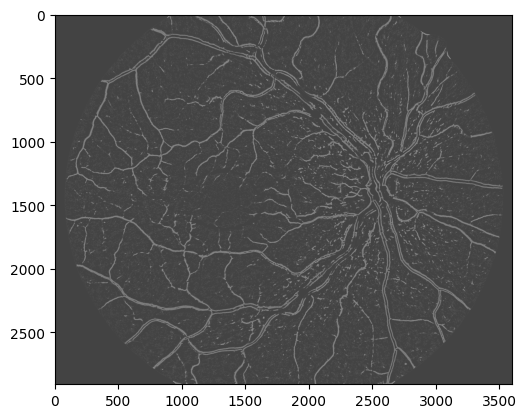

In [50]:
plt.imshow(test1,cmap='gray')

Text(0.5, 1.0, 'Local Otsu Thresholding')

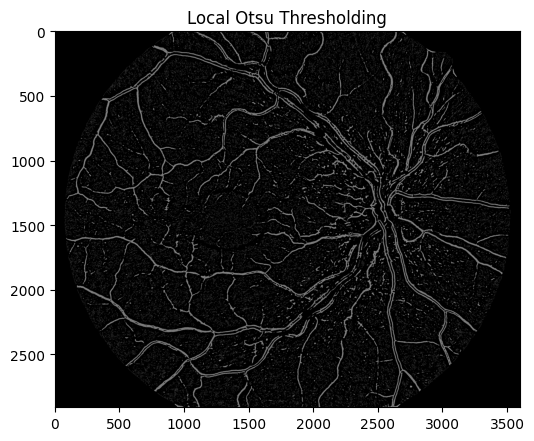

In [51]:
#local otsu thresholding on the fused image
lOtsu = LocalOtsu2(test1.astype('uint8'))
fig = plt.figure(figsize=(6, 6))
plt.imshow(lOtsu,cmap='gray')
plt.title("Local Otsu Thresholding")

Text(0.5, 1.0, 'Pixel/Area based Thresholding')

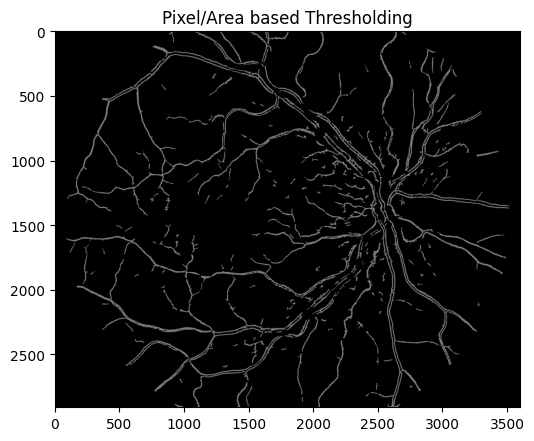

In [52]:
#area thresholding to remove non vessel regions
final = AreaThreshold(lOtsu ,200)
fig = plt.figure(figsize=(6, 6))
plt.imshow(final,cmap='gray')
plt.title("Pixel/Area based Thresholding")

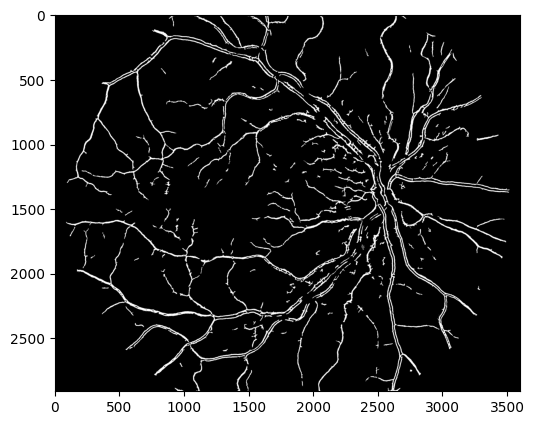

In [53]:
final[final!=0] = 255

fig = plt.figure(figsize=(6, 6))
plt.imshow(final,cmap='gray')

Text(0.5, 1.0, 'output')

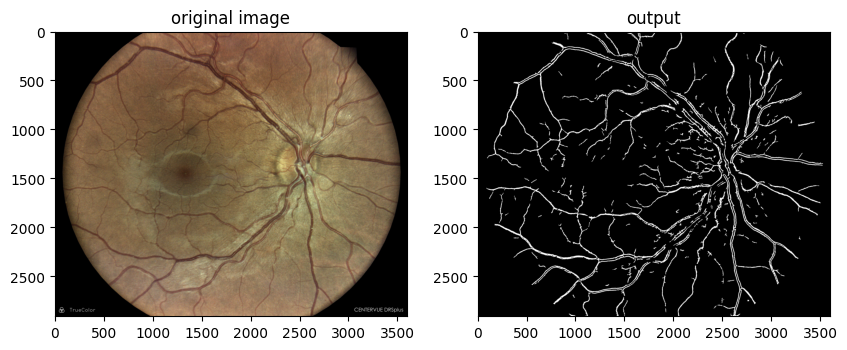

In [54]:
#Two images that have to be fused
fig = plt.figure(figsize=(10, 10))
fig.add_subplot(1, 2, 1)
plt.imshow(image,cmap='gray')
plt.title('original image')
fig.add_subplot(1, 2, 2)
plt.imshow(final,cmap='gray')
plt.title('output')

Validation

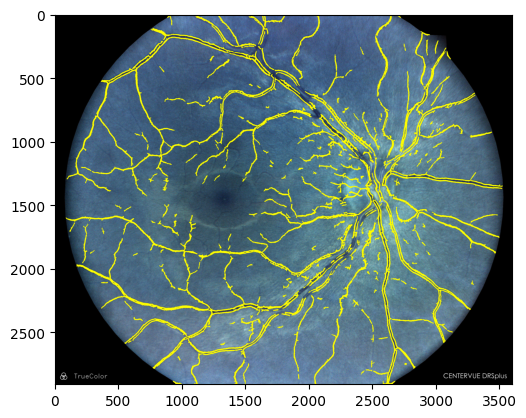

In [55]:
import cv2
import numpy as np

# Load the original and segmented images
original_image = image
segmented_image = final

# Convert the original image to RGB color space
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Create a copy of the original image to draw vessels
vessel_overlay = original_image.copy()

# Define the color for vessel overlay (e.g., bright yellow)
vessel_color = (255, 255, 0)

# Iterate through each pixel and draw vessels on the overlay image
for i in range(segmented_image.shape[0]):
    for j in range(segmented_image.shape[1]):
        if segmented_image[i, j] > 0:  # Assuming non-zero values represent vessels
            # Draw a yellow circle around vessel pixels
            cv2.circle(vessel_overlay, (j, i), 1, vessel_color, -1)

# Display the original image with vessel overlay
plt.imshow(vessel_overlay)



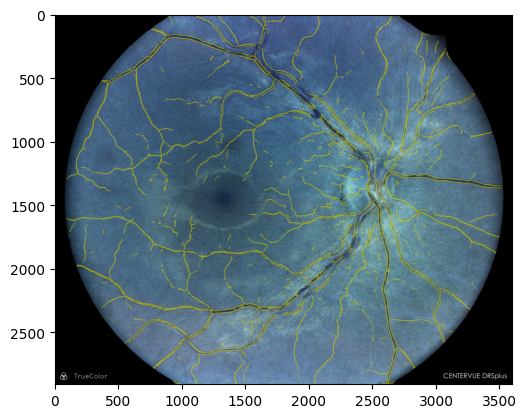

In [56]:
import cv2
import numpy as np

# Load the original and segmented images
original_image = image
segmented_image = final

# Convert the original image to RGB color space
original_image = cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB)

# Create a copy of the original image for overlay
overlay_image = original_image.copy()

# Set the transparency level for the vessel overlay (between 0 and 1)
transparency = 0.5

# Create a mask of the segmented vessels
vessel_mask = segmented_image > 0

# Set the color for the vessel overlay
vessel_color = (255, 255, 0)  # Green color for segmented vessels

# Apply the vessel mask and overlay the segmented vessels on the original image
overlay_image[vessel_mask] = (overlay_image[vessel_mask] * (1 - transparency) + np.array(vessel_color) * transparency).astype(np.uint8)

# Display the original image with vessel overlay
plt.imshow(overlay_image)

Using density

In [57]:
import cv2
import numpy as np

# Load the segmented image
segmented_image = final

# Calculate vessel density
total_pixels = segmented_image.size
vessel_pixels = np.count_nonzero(segmented_image)
vessel_density = vessel_pixels / total_pixels

# Calculate average width
contours, _ = cv2.findContours(segmented_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
total_width = 0
for contour in contours:
    _, _, width, _ = cv2.boundingRect(contour)
    total_width += width
average_width = total_width / len(contours)

# Calculate fractal dimension (optional)
# You can use libraries like scikit-image or mahotas for fractal dimension calculation

# Print the evaluation results
print(f"Vessel Density: {vessel_density:.4f}")
print(f"Average Width: {average_width:.4f}")


Vessel Density: 0.0581
Average Width: 119.2383


In [58]:
import cv2
import numpy as np

# Load the segmented images
image1 = cv2.imread('/content/drive/MyDrive/App/DATA_PREPROCESSING/A/_segmented_a01-CHU-l.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('/content/drive/MyDrive/App/DATA_PREPROCESSING/A++/_HHH_segmented_a01-CHU-l.jpg', cv2.IMREAD_GRAYSCALE)

# Calculate the connectivity of segmented vessels
connectivity1, _ = cv2.connectedComponents(image1)
connectivity2, _ = cv2.connectedComponents(image2)

# Assess continuity by counting the number of disconnected components
disconnected1 = connectivity1 - 1  # Subtract 1 to exclude the background component
disconnected2 = connectivity2 - 1

# Assess smoothness by calculating the number of vessel pixels compared to the total pixels
total_pixels1 = image1.size
vessel_pixels1 = np.count_nonzero(image1)
smoothness1 = vessel_pixels1 / total_pixels1

total_pixels2 = image2.size
vessel_pixels2 = np.count_nonzero(image2)
smoothness2 = vessel_pixels2 / total_pixels2

# Assess connectivity between different images
overlap = cv2.bitwise_and(image1, image2)
connectivity_overlap, _ = cv2.connectedComponents(overlap)
connected_vessels = connectivity_overlap - 1

# Print the assessment results
print("Image 1:")
print(f"Discontinuity: {disconnected1}")
print(f"Smoothness: {smoothness1:.4f}")
print()
print("Image 2:")
print(f"Discontinuity: {disconnected2}")
print(f"Smoothness: {smoothness2:.4f}")
print()
print("Connectivity across images:")
print(f"Connected Vessels: {connected_vessels}")


Image 1:
Discontinuity: 13082
Smoothness: 0.2515

Image 2:
Discontinuity: 11493
Smoothness: 0.0801

Connectivity across images:
Connected Vessels: 23050


In terms of assessing the quality of segmented vessels, a higher smoothness value is generally desired, indicating a more continuous and coherent vessel structure. Smoothness is often associated with well-segmented vessels that closely resemble the true vascular structure.

On the other hand, a higher discontinuity value indicates a larger number of disconnected vessel segments or fragmented vessels. This suggests that the segmentation algorithm might be producing more false positives or missing parts of the vessels, resulting in a less accurate segmentation.

Therefore, in the context of retinal vessel segmentation, a higher smoothness value and a lower discontinuity value are preferred. These characteristics indicate a more accurate and reliable segmentation output, closely resembling the true vessels in the retinal images.

When comparing different segmentation algorithms or variations of the same algorithm, you should look for the one that produces the highest smoothness and lowest discontinuity values, indicating a better quality segmentation.

In [59]:
import numpy as np


# Binarize the segmentation results (if necessary)
result1 = cv2.threshold(image1, 127, 255, cv2.THRESH_BINARY)[1]
result2 = cv2.threshold(image2, 127, 255, cv2.THRESH_BINARY)[1]

# Calculate the intersection and union between the two segmentation results
intersection = np.logical_and(image1, image2)
union = np.logical_or(image1, image2)

# Calculate the intersection and union between the two segmentation results
intersection = cv2.bitwise_and(result1, result2)
union = cv2.bitwise_or(result1, result2)

# Calculate the intersection over union (IoU) similarity
iou = np.sum(intersection) / np.sum(union)

# Print the IoU similarity
print("Intersection over Union (IoU):", iou)


Intersection over Union (IoU): 0.15823995862445078


The IoU provides a measure of the agreement or overlap between the two segmentation results, indicating how similar they are in terms of capturing the retinal vessels.

In [60]:
def calculate_hausdorff_distance(mask1, mask2):
    # Find the coordinates of the non-zero pixels in the masks
    pixels_mask1 = np.array(np.where(mask1)).T
    pixels_mask2 = np.array(np.where(mask2)).T

    # Compute the pairwise distances between pixels in mask1 and mask2
    distances = np.linalg.norm(pixels_mask1[:, None] - pixels_mask2, axis=2)

    # Calculate the Hausdorff distance as the maximum distance between the two masks
    hausdorff_distance = np.max(np.min(distances, axis=1))

    return hausdorff_distance


In [ ]:
import cv2
import numpy as np

# Step 1: Segmentation
# Apply different segmentation algorithms to obtain multiple segmentations
segmentation1 = image1
segmentation2 = image2

# Add more segmentation results as needed

# Step 2: Fusion of Segmentations
# Combine the segmentations using a consensus-based method
consensus_segmentation = np.logical_or.reduce((segmentation1, segmentation2))
# You can use other fusion methods based on your requirements

# Step 3: Evaluation
# Compare the consensus segmentation with the individual segmentations
jaccard_scores = []
hausdorff_distances = []

# Calculate evaluation metrics for each segmentation
jaccard_scores.append(np.sum(consensus_segmentation * segmentation1) / np.sum(np.logical_or(consensus_segmentation, segmentation1)))
jaccard_scores.append(np.sum(consensus_segmentation * segmentation2) / np.sum(np.logical_or(consensus_segmentation, segmentation2)))

# Calculate the Hausdorff distance for each segmentation
hausdorff_distances.append(calculate_hausdorff_distance(consensus_segmentation, segmentation1))
hausdorff_distances.append(calculate_hausdorff_distance(consensus_segmentation, segmentation2))

# Print the evaluation results
print("Jaccard Scores:", jaccard_scores)
print("Hausdorff Distances:", hausdorff_distances)
